In [71]:
import numpy as np
import pandas as pd
import re
from konlpy.tag import Okt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import seaborn as sns

### pyplot 폰트 관련 설정

In [74]:
# 폰트 설정
font_name = font_manager.FontProperties(fname='./NotoSansKR-Regular.otf').get_name()
rc('font', family=font_name)
# 폰트 사이즈 설정
plt.rcParams['font.size'] = 15
# 폰트 설정 다른 방법
# plt.reParams['font.family'] = 'Malgun Gothic'
# 화면크기 설정
plt.rcParams['figure.figsize'] = (18,16)

### 데이터 불러오기

In [2]:
df_path = './210721_기업텍스트분석.xlsx'

df = pd.read_excel(df_path, sheet_name=0)
df

,NO,SQ1,Q9t1
0,1000004,1,비정규직보다는 정규직채용을 해주시고 많은 복리후생을 챙겨주세요
1,1000006,1,경제억압개선
2,1000003,1,소비자 중심의 생각
3,1000009,2,없음
4,1000013,2,경제발전에 큰 기여를 하도록 힘써야한다고 생각한다.
...,...,...,...
9565,1011600,1,코로나 극복을 위해 경제활성화에 앞서주고 환경오염(과대포장 등)을 덜 하도록 노력하...
9566,1011604,1,높은 경제적 지위를 이용해 낙하산식 인사 운영 분식회계 등 비리를 척결하고 공정한...
9567,1011607,1,불이익 요소 금지
9568,1011609,1,청년들의 일자리가 부족하다. 채용을 늘렸아면 좋겠다


### 텍스트 전처리 함수

In [3]:
# 특수기호 제거
def text_preprocessing(text):
    sentence = text.split(' ')
    prepro_sentence = []
    for word in sentence:
        prepro_word = re.sub(r'[^가-힣0-9a-zA-Z]', '', word)
        prepro_sentence.append(prepro_word)
    result = ' '.join(prepro_sentence)
    return result

# okt 형태소 분석기 토크나이징
def tokenize(text):
    okt = Okt()
    tokens = okt.pos(text)
    
    stop_words = ['없음', '없다', '없습니다', '없어요', 
                  '', '모름', '딱히 없다', '잘 모르겠다', 
                  '없슴', '감사합니다', '특별히 없음', '모르겠음',
                 '딱히', '특별히', '모르겠다', '잘모르겠습니다', '잘']
    
    tokens = [(word, tag) for word, tag in tokens if word not in stop_words]
    
    total_words = []
    for word, tag in tokens:
        if tag not in ['Josa']:
            total_words.append(word)
    result = ' '.join(total_words)
    return result

### 텍스트 전처리

In [4]:
# 특수기호 제거
df['Q9t1'] = df['Q9t1'].map(text_preprocessing)
# 형태소 분석
df['Q9t1'] = df['Q9t1'].map(tokenize)
# 비어있는값 Nan 만들기
df['Q9t1'] = df['Q9t1'][df['Q9t1'] != '']
# Nan 행 지우기
new_df = df.dropna(axis=0)

### 불용어 제거하기

In [18]:
# 문장을 리스트에 담기
new_text = [text for text in new_df['Q9t1'].values]

# 단어만 분리해서 new_test에 담기 (불용어 제거하면서)
new_test = []
new_stopwords = ['들', '적', '하는', '창','더', '촐', '출', '한다', '합니다', '있는', '것',
                '위해', '했으면', '위', '수', '할', '좀', '및', '해야', '해', '하지', '리창', 
                 '리', '함', '제', '등', '다', '경', '다 ', '경 ', '좋겠다', '좋겠습니다', 
                 '해주세요', '되었으면', '대한', '바랍니다', '이', '주', '하여', '주세요', '입니다']
for new in new_text:
    for word in new.split(' '):
        if word not in new_stopwords:
            new_test.append(word)

In [25]:
all_join = ' '.join(new_test)

In [33]:
total_word = []
total_word.append(all_join)

### TF-IDF

In [78]:
tfidf = TfidfVectorizer(max_features=100, min_df=10, ngram_range=(2,2)).fit(new_df['Q9t1'])

In [79]:
# 단어사전
tfidf.vocabulary_

{'발전 기여': 37,
 '생각 한다': 49,
 '이윤 추구': 58,
 '기업 기업인': 19,
 '하면 좋겠다': 87,
 '제품 생산': 72,
 '사회 책임': 45,
 '직원 복지': 77,
 '복지 신경': 39,
 '기업 발전': 23,
 '투명한 기업': 84,
 '좋은 일자리': 73,
 '투명한 경영': 83,
 '되었으면 좋겠습니다': 32,
 '양질 일자리': 55,
 '일자리 많이': 63,
 '기업 되었으면': 21,
 '되었으면 합니다': 33,
 '해야 한다': 92,
 '상생 하는': 47,
 '하는 기업': 85,
 '근로 복지': 4,
 '복지 향상': 41,
 '생각 하는': 48,
 '기업 되길': 20,
 '되길 바랍니다': 30,
 '환경 개선': 97,
 '많은 일자리': 34,
 '일자리 출과': 65,
 '세금 납부': 52,
 '기업 이익': 27,
 '위해 노력': 57,
 '투명 경영': 82,
 '환경 생각': 99,
 '근로자 처우': 14,
 '처우 개선': 78,
 '있는 기업': 69,
 '최선 다해': 80,
 '기술 개발': 16,
 '했으면 한다': 95,
 '일자리 출에': 66,
 '근무 환경': 15,
 '일자리 제공': 64,
 '일자 리창': 62,
 '근로 환경': 5,
 '코로나 시대': 81,
 '사회 환원': 46,
 '했으면 좋겠다': 93,
 '했으면 좋겠습니다': 94,
 '근로자 복지': 9,
 '기업 문화': 22,
 '어려운 시기': 56,
 '국가 발전': 3,
 '근로자 안전': 12,
 '근로자 상생': 10,
 '청년 일자리': 79,
 '좋은 제품': 74,
 '근로자 보호': 8,
 '하는 사람': 86,
 '생각 합니다': 50,
 '했으면 합니다': 96,
 '근로자 기업': 6,
 '갑질 근절': 0,
 '국가 경제': 2,
 '먼저 생각': 36,
 '신경 써야': 53,
 '하지 않고': 88,
 '복지 개선': 38,
 '하청 업체': 89,


In [80]:
# 단어사전 정렬
word_dict = sorted(tfidf.vocabulary_.items())
word_dict

[('갑질 근절', 0),
 ('경제 발전', 1),
 ('국가 경제', 2),
 ('국가 발전', 3),
 ('근로 복지', 4),
 ('근로 환경', 5),
 ('근로자 기업', 6),
 ('근로자 대한', 7),
 ('근로자 보호', 8),
 ('근로자 복지', 9),
 ('근로자 상생', 10),
 ('근로자 생각', 11),
 ('근로자 안전', 12),
 ('근로자 존중', 13),
 ('근로자 처우', 14),
 ('근무 환경', 15),
 ('기술 개발', 16),
 ('기업 경영', 17),
 ('기업 근로자', 18),
 ('기업 기업인', 19),
 ('기업 되길', 20),
 ('기업 되었으면', 21),
 ('기업 문화', 22),
 ('기업 발전', 23),
 ('기업 사회', 24),
 ('기업 운영', 25),
 ('기업 이윤', 26),
 ('기업 이익', 27),
 ('노력 해야', 28),
 ('대기업 중소기업', 29),
 ('되길 바랍니다', 30),
 ('되었으면 좋겠다', 31),
 ('되었으면 좋겠습니다', 32),
 ('되었으면 합니다', 33),
 ('많은 일자리', 34),
 ('많이 만들어', 35),
 ('먼저 생각', 36),
 ('발전 기여', 37),
 ('복지 개선', 38),
 ('복지 신경', 39),
 ('복지 우선', 40),
 ('복지 향상', 41),
 ('사람 먼저', 42),
 ('사회 공헌', 43),
 ('사회 기여', 44),
 ('사회 책임', 45),
 ('사회 환원', 46),
 ('상생 하는', 47),
 ('생각 하는', 48),
 ('생각 한다', 49),
 ('생각 합니다', 50),
 ('서로 상생', 51),
 ('세금 납부', 52),
 ('신경 써야', 53),
 ('신경 써주세요', 54),
 ('양질 일자리', 55),
 ('어려운 시기', 56),
 ('위해 노력', 57),
 ('이윤 추구', 58),
 ('이익 사회', 59),
 ('이익 중요하지만', 

In [81]:
# idx2word
idx2word = {idx:word for word, idx in word_dict}
idx2word

{0: '갑질 근절',
 1: '경제 발전',
 2: '국가 경제',
 3: '국가 발전',
 4: '근로 복지',
 5: '근로 환경',
 6: '근로자 기업',
 7: '근로자 대한',
 8: '근로자 보호',
 9: '근로자 복지',
 10: '근로자 상생',
 11: '근로자 생각',
 12: '근로자 안전',
 13: '근로자 존중',
 14: '근로자 처우',
 15: '근무 환경',
 16: '기술 개발',
 17: '기업 경영',
 18: '기업 근로자',
 19: '기업 기업인',
 20: '기업 되길',
 21: '기업 되었으면',
 22: '기업 문화',
 23: '기업 발전',
 24: '기업 사회',
 25: '기업 운영',
 26: '기업 이윤',
 27: '기업 이익',
 28: '노력 해야',
 29: '대기업 중소기업',
 30: '되길 바랍니다',
 31: '되었으면 좋겠다',
 32: '되었으면 좋겠습니다',
 33: '되었으면 합니다',
 34: '많은 일자리',
 35: '많이 만들어',
 36: '먼저 생각',
 37: '발전 기여',
 38: '복지 개선',
 39: '복지 신경',
 40: '복지 우선',
 41: '복지 향상',
 42: '사람 먼저',
 43: '사회 공헌',
 44: '사회 기여',
 45: '사회 책임',
 46: '사회 환원',
 47: '상생 하는',
 48: '생각 하는',
 49: '생각 한다',
 50: '생각 합니다',
 51: '서로 상생',
 52: '세금 납부',
 53: '신경 써야',
 54: '신경 써주세요',
 55: '양질 일자리',
 56: '어려운 시기',
 57: '위해 노력',
 58: '이윤 추구',
 59: '이익 사회',
 60: '이익 중요하지만',
 61: '이익 추구',
 62: '일자 리창',
 63: '일자리 많이',
 64: '일자리 제공',
 65: '일자리 출과',
 66: '일자리 출에',
 67: '일자리 출을',
 68: '입장 생각',


In [82]:
#tfidf_matrix = tfidf.transform(new_df['Q9t1'])
tfidf_matrix = tfidf.transform(total_word)
tfidf_matrix.shape

(1, 100)

In [83]:
tfidf_matrix.toarray()[0]

array([0.06049673, 0.07180539, 0.11754287, 0.05271571, 0.14466778,
       0.08274882, 0.0530419 , 0.        , 0.05663287, 0.44440632,
       0.0699478 , 0.06463886, 0.05889818, 0.0611635 , 0.07062991,
       0.06686778, 0.07061448, 0.14059043, 0.10568683, 0.19307287,
       0.09338363, 0.        , 0.12576929, 0.06620108, 0.09705933,
       0.15037835, 0.0585712 , 0.1541854 , 0.        , 0.05534807,
       0.        , 0.        , 0.        , 0.        , 0.15558587,
       0.05271571, 0.06463886, 0.06049673, 0.08454145, 0.13992393,
       0.0550077 , 0.07764746, 0.05663287, 0.1813113 , 0.06273735,
       0.11086054, 0.17833823, 0.        , 0.        , 0.        ,
       0.        , 0.08810194, 0.1105303 , 0.05271571, 0.0585712 ,
       0.21601675, 0.05073573, 0.        , 0.06652887, 0.06431124,
       0.0585712 , 0.08733825, 0.        , 0.23893726, 0.1188686 ,
       0.11388306, 0.09338363, 0.05468122, 0.05073573, 0.        ,
       0.05271571, 0.06463886, 0.0530419 , 0.05073573, 0.05468

In [84]:
# argsort 내림차순
(-tfidf_matrix.toarray()[0]).argsort()

array([ 9, 83, 63, 55, 19, 43, 77, 46, 34, 27, 25,  4, 17, 39, 22, 97, 64,
        2, 99, 65, 45, 52, 18, 84, 78, 24, 82, 20, 66, 51, 61, 38,  5, 90,
       41, 81, 98,  1, 14, 16, 10, 80, 15, 58, 23, 71, 36, 11, 59, 44, 13,
        0, 37, 12, 54, 26, 60, 75,  8, 42, 29, 79, 40, 89, 67, 74,  6, 72,
       35,  3, 76, 53, 70, 68, 56, 73, 91, 92, 93, 94, 88, 95, 96, 87, 86,
       48,  7, 21, 28, 50, 30, 69, 31, 32, 33, 62, 57, 47, 85, 49],
      dtype=int64)

In [85]:
# 가장 높은 tfidf 단어 뽑기
idx2word[(-tfidf_matrix.toarray()[0]).argsort()[0]]

'근로자 복지'

In [86]:
# 가장 높은 tfidf는 몇인가
tfidf_matrix.toarray()[0][(-tfidf_matrix.toarray()[0]).argsort()[0]]

0.44440631570498595

In [87]:
'{:.2f}'.format(tfidf_matrix.toarray()[0][(-tfidf_matrix.toarray()[0]).argsort()[0]])

'0.44'

In [88]:
new_word = []
new_tfidf = []

for i in range(10,0,-1):
    new_word.append(idx2word[(-tfidf_matrix.toarray()[0]).argsort()[i-1]])
    new_tfidf.append(tfidf_matrix.toarray()[0][(-tfidf_matrix.toarray()[0]).argsort()[i-1]])

### tfidf 그래프 그리기

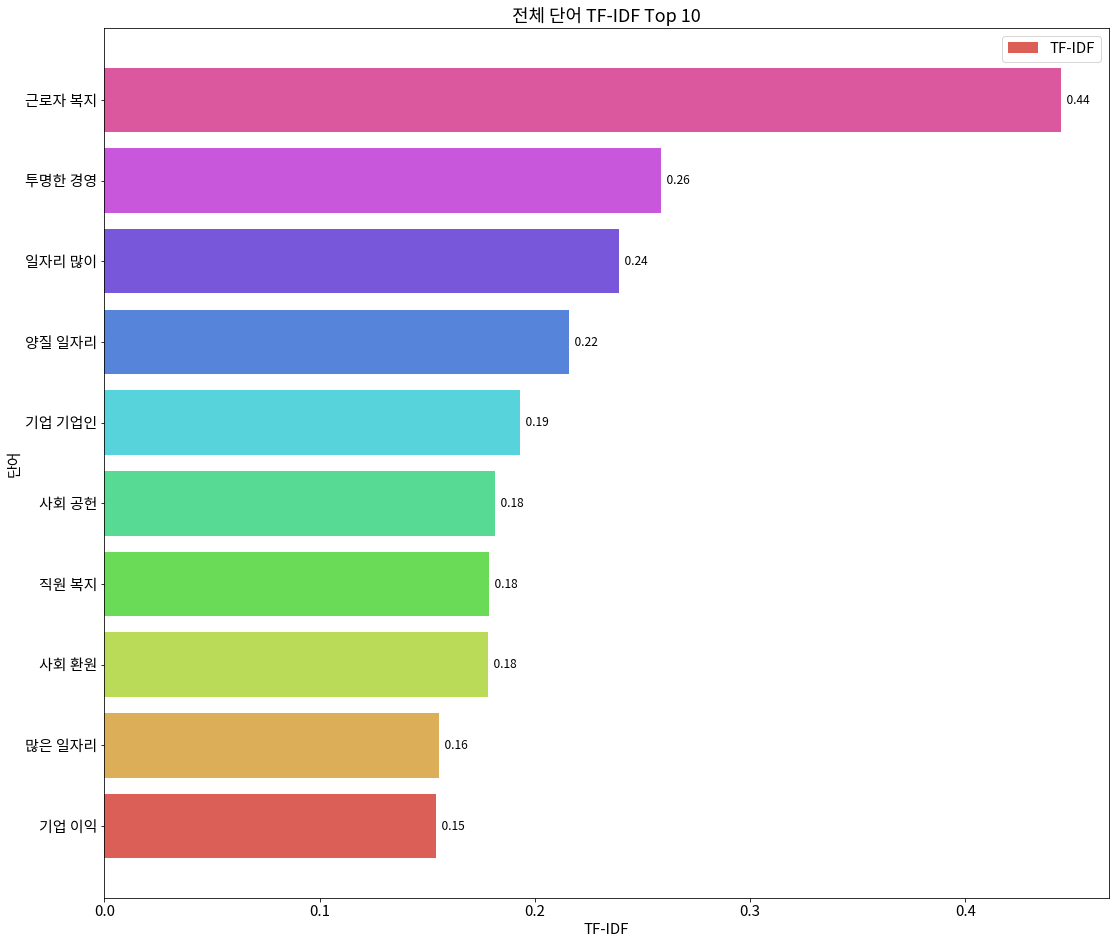

In [90]:
#plt.figure(figsize=(20,16))
colors = sns.color_palette('hls', 10) # ==> sns.color_palette('파레트 종류', 색 개수)
plt.barh(new_word, new_tfidf, 
         label='TF-IDF',
         color=colors)
plt.legend()
plt.ylabel('단어')
plt.xlabel('TF-IDF')
# plt.xlim(0, 2000)
plt.title('전체 단어 TF-IDF Top 10')
plt.yticks(new_word) # ==> 세로 틱 범위 표시

for i, x in enumerate(new_word):
    tfidf = '  {:.2f}'.format(new_tfidf[i])
    plt.text(new_tfidf[i], x, tfidf, fontsize=12, color='#000000',
            horizontalalignment='left', verticalalignment='center')
plt.savefig('./Total_word_tfidf.png')
plt.show()

### 워드 클라우드

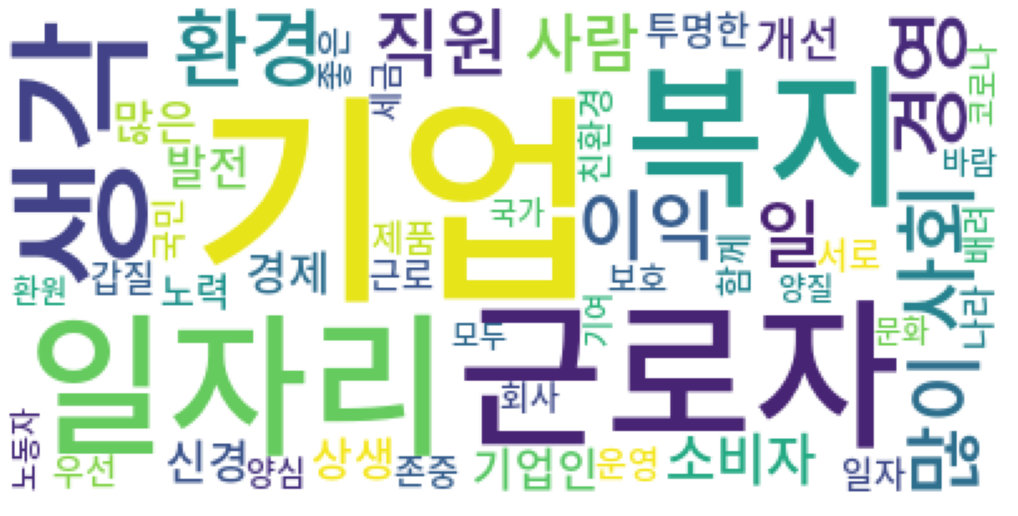

In [20]:
wordcloud = WordCloud(font_path='./NotoSansKR-Medium.otf',
                     relative_scaling = 0.2,
                     background_color='white').generate_from_frequencies(dict(keyword))
#plt.figure(figsize=(18,16))
plt.imshow(wordcloud)
plt.axis('off')
#plt.savefig('./female_word_top50_wordcloud.png')
plt.show()